In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [ ]:
import pandas as pd
import numpy as np

# CONSTANTS: S and Ia values based of land use and CN (see Excel sheet)
CN = 84
S = 1000/CN -10 #inches
I = .05*S #inches

# CONSTANTS: to calculate hydropower
eta = 0.8 # efficiency of turbines, assumed value
rho = 998 # density of water, 1000 kg/m^3
g = 9.81 # gravitational acceleration, 9.81 m/s^2

class Reservoir:

    def __init__(self, SA, num_turb, capacity, tail_elev, pool_elev, bottom_elev, fish_pass, area):
        self.SA = SA # reservoir surface area (sq m)
        self.num_turb = num_turb # number of turbines at dam
        self.capacity = capacity # generation capacity (kW)
        self.tail_elev = tail_elev*0.3046 # tailwater elevation (ft -> m)
        self.pool_elev = pool_elev*0.3046 # reservoir maximum pooling elevation (ft -> m)
        self.bottom_elev = bottom_elev*0.3046 # reservoir bottom elevation (ft -> m)
        self.fish_pass = fish_pass # fish passage rate
        self.area = area # watershed area (sq m)
        self.max_storage = SA * (pool_elev - bottom_elev)
    
    def simulate_fish_passage(self, keep):
        if keep == 1: # remove dam
            return 1
        return self.fish_pass
    
    def calc_runoff(self, precip_data):
        Area = self.area
        Q = np.where(precip_data <= I, 0, (precip_data-I)**2 / (precip_data - I + S))
        # Q = ((P-I)**2 / (P - I + S))
        Q = Q*0.0254 #convert to meters
        Qv = Q * Area
        #TEST SCALE UP FACTOR
        Qv *= 10
        return Qv
    
    def simulate_inflow(self, precip_data, inflow_data):
        runoff = self.calc_runoff(precip_data) # gives volume per day (m^3/d)
        upstream_flow = inflow_data*86400*0.0283 # gives volume per day (m^3/d)

        return runoff + upstream_flow
    
    def simulate_storage(self, initial_storage, keep, inflow, outflow):
        max_storage = self.max_storage
        storage = np.zeros(len(inflow))

        if keep == 0: # no dam
            return storage
        
        # else: yes dam
        storage[0] = initial_storage
        for i in range(1,len(storage)):
            storage[i] = max(min(storage[i-1] + inflow[i] - outflow[i], max_storage), 0)
        
        return storage
    
    def simulate_head(self, storage):
        return None
    
    def simulate_hydropower(self, head, flow, keep):
        P = rho * g * head * eta * self.num_turb * flow

        if keep == 0: # no dam
            P = 0
        # else: yes dam
        P = min((P/1000), self.capacity) # maximum power output is less than rated capacity of turbine
        P = max(P, 0) # non-negativity constraint
        energy = (P/1000) * 24 # Watts to kW multiplied by hours in a day to get kWh=
        return energy
    
    # you can see the latest changes :)
    


## Import and visualize data

In [28]:
# process outflow data
outflow_data = pd.read_csv('4200 Modified Average Daily Streamflows.csv')
outflow_data.rename(columns={'Ice Harbor Daily Streamflows (unit:cfs)': 'Ice Harbor outflow (cfs)'}, inplace=True)
outflow_data.rename(columns={'Lower Monumental (unit:cfs)': 'Lower Monumental outflow (cfs)'}, inplace=True)
outflow_data.rename(columns={'Little Goose (unit:cfs)': 'Little Goose outflow (cfs)'}, inplace=True)
outflow_data.rename(columns={'Lower Granite (unit:cfs)': 'Lower Granite outflow (cfs)'}, inplace=True)
outflow_data['date'] = pd.to_datetime(outflow_data['date'])
outflow_data.rename(columns={'date':'datetime'}, inplace=True)

# process precipitation data for runoff calculations
precip_data = pd.read_csv('NOAAprecipitation_data_LEWISTON_AIRPORT_ID.csv')
precip_data = precip_data.drop(['STATION', 'NAME', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 'SNWD', 'SNOW'], axis=1)
precip_data.rename(columns={'PRCP':'rainfall (in)', 'DATE':'datetime'}, inplace=True)
precip_data['datetime'] = pd.to_datetime(precip_data['datetime'], format='%Y-%m-%d')
precip_data['rainfall (in)'] = precip_data['rainfall (in)'].fillna(0) #replaces nan with 0

# process Clearwater River flow
upstream_flow = pd.read_csv('nwis.waterdata.usgsclearwater.txt', sep='\t', header=27)
upstream_flow = upstream_flow.drop(0)
upstream_flow['datetime'] = pd.to_datetime(upstream_flow['datetime'], format='%Y-%m-%d %H:%M').dt.date
upstream_flow = upstream_flow.drop(['agency_cd', 'site_no', 'tz_cd', '191671_00060_cd'], axis=1)
upstream_flow.rename(columns={'191671_00060':'upstream flow (cfs)'}, inplace=True)
upstream_flow['upstream flow (cfs)'] = pd.to_numeric(upstream_flow['upstream flow (cfs)'], errors='coerce')
upstream_flow = upstream_flow.groupby('datetime')['upstream flow (cfs)'].mean().reset_index()
upstream_flow['datetime'] = pd.to_datetime(upstream_flow['datetime'])

# process Snake river flow
snake_flow = pd.read_csv('snakeriverAnatoneUSGSflow.txt', sep='\t', header=28)
snake_flow = snake_flow.drop(0)
snake_flow['datetime'] = pd.to_datetime(upstream_flow['datetime'], format='%Y-%m-%d %H:%M').dt.date
snake_flow = snake_flow.drop(['agency_cd', 'site_no', 'tz_cd', '151907_00060_cd'], axis=1)
snake_flow.rename(columns={'151907_00060':'Snake flow (cfs)'}, inplace=True)
snake_flow['Snake flow (cfs)'] = pd.to_numeric(snake_flow['Snake flow (cfs)'], errors='coerce')
snake_flow = snake_flow.groupby('datetime')['Snake flow (cfs)'].mean().reset_index()
snake_flow['datetime'] = pd.to_datetime(snake_flow['datetime'])


# process Tucannon river flow
tucannon_flow = pd.read_csv('tucannonriverdailymean.txt', sep='\t', header=25)
tucannon_flow = tucannon_flow.drop(0)
tucannon_flow = tucannon_flow.drop(['agency_cd', 'site_no', '150225_00060_00003_cd'], axis=1)
tucannon_flow.rename(columns={'150225_00060_00003':'Tucannon flow (cfs)'}, inplace=True)
tucannon_flow['datetime'] = pd.to_datetime(tucannon_flow['datetime'], format='%Y-%m-%d')
tucannon_flow['Tucannon flow (cfs)'] = pd.to_numeric(tucannon_flow['Tucannon flow (cfs)'], errors='coerce')

# process Palouse river flow
palouse_flow = pd.read_csv('palouseriverdailydischarge.csv', usecols=['time','value'])
palouse_flow.rename(columns={'value':'Palouse flow (cfs)', 'time':'datetime'}, inplace=True)
palouse_flow['datetime'] = pd.to_datetime(palouse_flow['datetime'], format='%Y-%m-%d')
palouse_flow['Palouse flow (cfs)'] = pd.to_numeric(palouse_flow['Palouse flow (cfs)'], errors='coerce')

# merge Tucannon and Palouse
lower_mon_trib = palouse_flow.merge(tucannon_flow, how='inner', on=['datetime'])
lower_mon_trib['Tributary flow (cfs)'] = lower_mon_trib['Palouse flow (cfs)'] + lower_mon_trib['Tucannon flow (cfs)']
lower_mon_trib = lower_mon_trib.drop(['Palouse flow (cfs)','Tucannon flow (cfs)'], axis=1)

# merge the dataframes
flow_data = outflow_data.merge(upstream_flow, how='inner', on=['datetime'])
input_data = flow_data.merge(precip_data, how='inner', on=['datetime'])
input_data = input_data.merge(snake_flow, how='inner', on=['datetime'])
input_data['upstream flow (cfs)'] = input_data['upstream flow (cfs)'] + input_data['Snake flow (cfs)']
input_data = input_data.merge(lower_mon_trib, how='inner', on=['datetime'])
input_data = input_data.drop(columns='Snake flow (cfs)')

input_data = input_data[input_data['datetime'] > datetime(1995,1,1)]

display(input_data)

C:\Users\grcra\AppData\Local\Temp\ipykernel_47488\2233177929.py:18: DtypeWarning: Columns (1,4) have mixed types. Specify dtype option on import or set low_memory=False.
  upstream_flow = pd.read_csv('nwis.waterdata.usgsclearwater.txt', sep='\t', header=27)
C:\Users\grcra\AppData\Local\Temp\ipykernel_47488\2233177929.py:28: DtypeWarning: Columns (1,4) have mixed types. Specify dtype option on import or set low_memory=False.
  snake_flow = pd.read_csv('snakeriverAnatoneUSGSflow.txt', sep='\t', header=28)


,datetime,Ice Harbor outflow (cfs),Lower Monumental outflow (cfs),Little Goose outflow (cfs),Lower Granite outflow (cfs),upstream flow (cfs),rainfall (in),Tributary flow (cfs)
0,1998-07-04,82107,81510,81118,81344,51241.666667,0.00,233.0
1,1998-07-05,81001,79527,79123,78330,47194.791667,0.00,245.0
2,1998-07-06,76627,74543,74135,73264,45203.125000,0.00,249.0
3,1998-07-07,72334,69721,69333,68155,43260.416667,0.00,229.0
4,1998-07-08,64410,61751,61367,60318,42294.791667,0.02,224.0
...,...,...,...,...,...,...,...,...
7353,2018-09-26,17428,18068,17945,17918,12562.083333,0.00,142.9
7354,2018-09-27,17526,18607,18484,18519,12548.105263,0.00,143.7
7355,2018-09-28,17245,18291,18170,18192,12532.187500,0.00,142.3
7356,2018-09-29,17863,18637,18515,18493,12505.416667,0.00,142.5


### Visualize one year

Text(0, 0.5, 'Outflow data from each dam (cfs)')

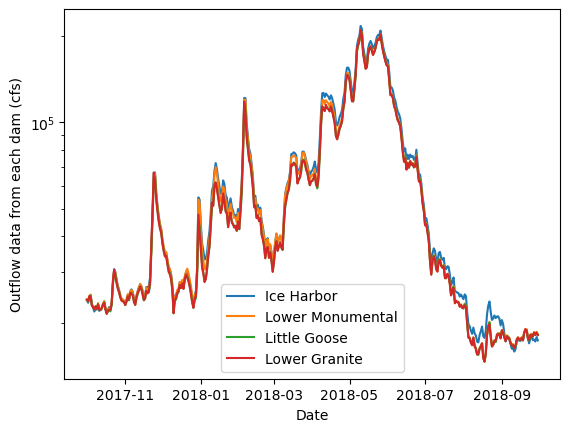

In [16]:
sns.lineplot(x='datetime', y='Ice Harbor outflow (cfs)', data=outflow_data[-365:], label='Ice Harbor')
sns.lineplot(x='datetime', y='Lower Monumental outflow (cfs)', data=outflow_data[-365:], label='Lower Monumental')
sns.lineplot(x='datetime', y='Little Goose outflow (cfs)', data=outflow_data[-365:], label='Little Goose')
sns.lineplot(x='datetime', y='Lower Granite outflow (cfs)', data=outflow_data[-365:], label='Lower Granite')

plt.yscale('log')
plt.xlabel('Date')
plt.ylabel('Outflow data from each dam (cfs)')

Text(0, 0.5, 'Streamflow (cfs)')

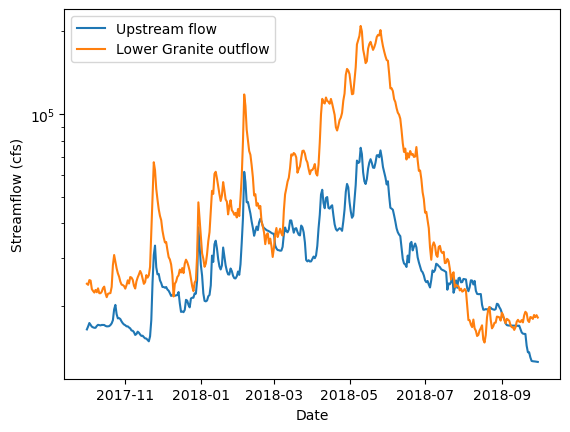

In [17]:
sns.lineplot(x='datetime', y='upstream flow (cfs)', data=input_data[-365:], label='Upstream flow')
sns.lineplot(x='datetime', y='Lower Granite outflow (cfs)', data=input_data[-365:], label='Lower Granite outflow')

plt.yscale('log')
plt.xlabel('Date')
plt.ylabel('Streamflow (cfs)')

Text(0.5, 1.0, 'Regional precipitation')

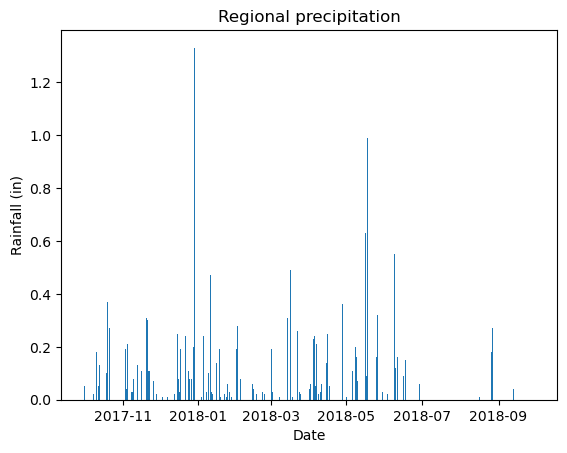

In [18]:
plt.bar(x=input_data['datetime'][-365:], height=input_data['rainfall (in)'][-365:])

plt.xlabel('Date')
plt.ylabel('Rainfall (in)')
plt.title('Regional precipitation')

### Visualize entire dataset

Text(0, 0.5, 'Outflow data from each dam (cfs)')

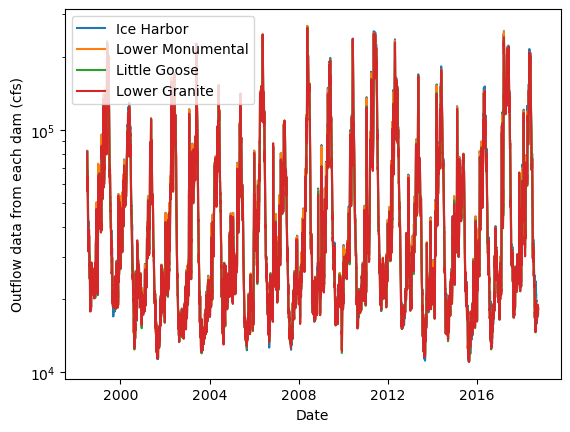

In [19]:
sns.lineplot(x='datetime', y='Ice Harbor outflow (cfs)', data=input_data, label='Ice Harbor')
sns.lineplot(x='datetime', y='Lower Monumental outflow (cfs)', data=input_data, label='Lower Monumental')
sns.lineplot(x='datetime', y='Little Goose outflow (cfs)', data=input_data, label='Little Goose')
sns.lineplot(x='datetime', y='Lower Granite outflow (cfs)', data=input_data, label='Lower Granite')

plt.yscale('log')
plt.xlabel('Date')
plt.ylabel('Outflow data from each dam (cfs)')

Text(0, 0.5, 'Streamflow (cfs)')

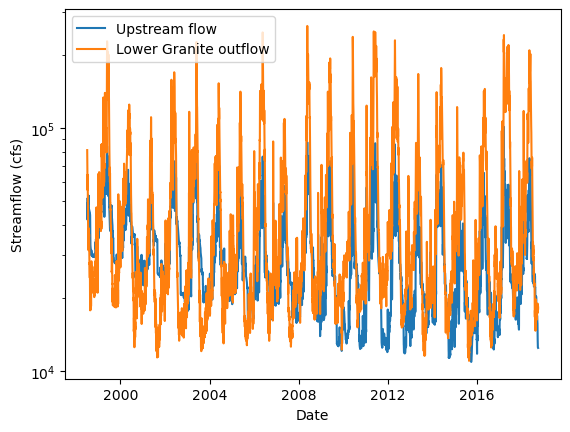

In [20]:
sns.lineplot(x='datetime', y='upstream flow (cfs)', data=input_data, label='Upstream flow')
sns.lineplot(x='datetime', y='Lower Granite outflow (cfs)', data=input_data, label='Lower Granite outflow')

plt.yscale('log')
plt.xlabel('Date')
plt.ylabel('Streamflow (cfs)')

Text(0.5, 1.0, 'Regional precipitation')

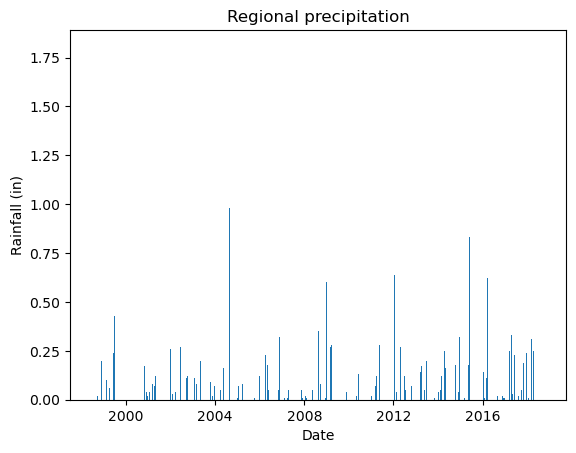

In [21]:
plt.bar(x=input_data['datetime'], height=input_data['rainfall (in)'])

plt.xlabel('Date')
plt.ylabel('Rainfall (in)')
plt.title('Regional precipitation')

## Initialize reservoirs

In [19]:
# from Reservoir import Reservoir

ice_harbor = Reservoir(SA=9200*4047,num_turb=6,capacity=603000,tail_elev=339,pool_elev=446,bottom_elev=310,fish_pass=0.965, area=550_000_000)
lower_monumental = Reservoir(SA=6590*4047,num_turb=6,capacity=810000,tail_elev=439,pool_elev=548.3,bottom_elev=406,fish_pass=0.965, area=1_610_000_000)
little_goose = Reservoir(SA=10025*4047,num_turb=6,capacity=903000,tail_elev=539,pool_elev=646.5,bottom_elev=500,fish_pass=0.9775, area=1_175_000_000)
lower_granite = Reservoir(SA=8900*4047,num_turb=6,capacity=810000,tail_elev=636,pool_elev=746.5,bottom_elev=590,fish_pass=1, area=2_477_000_000)

## Simulate reservoirs

### Lower Granite

In [21]:
input_data['Lower Granite inflow (m^3/d)'] = lower_granite.simulate_inflow(input_data['rainfall (in)'].values, input_data['upstream flow (cfs)'].values)
runoff = lower_granite.calc_runoff(input_data['rainfall (in)'].values)
input_data['Lower granite storage (m^3)'] = lower_granite.simulate_storage(4_000_000_000, 1, input_data['Lower Granite inflow (m^3/d)'].values, input_data['Lower Granite outflow (cfs)'].values*86400*0.0283)

display(input_data)

,datetime,Ice Harbor outflow (cfs),Lower Monumental outflow (cfs),Little Goose outflow (cfs),Lower Granite outflow (cfs),upstream flow (cfs),rainfall (in),Tributary flow (cfs),Lower Granite inflow (m^3/d),Lower granite storage (m^3)
0,1998-07-04,82107,81510,81118,81344,51241.666667,0.00,233.0,1.252920e+08,4.000000e+09
1,1998-07-05,81001,79527,79123,78330,47194.791667,0.00,245.0,1.153969e+08,3.923871e+09
2,1998-07-06,76627,74543,74135,73264,45203.125000,0.00,249.0,1.105271e+08,3.855258e+09
3,1998-07-07,72334,69721,69333,68155,43260.416667,0.00,229.0,1.057769e+08,3.794388e+09
4,1998-07-08,64410,61751,61367,60318,42294.791667,0.02,224.0,1.034158e+08,3.750319e+09
...,...,...,...,...,...,...,...,...,...,...
7353,2018-09-26,17428,18068,17945,17918,12562.083333,0.00,142.9,3.071580e+07,2.137687e+08
7354,2018-09-27,17526,18607,18484,18519,12548.105263,0.00,143.7,3.068162e+07,1.991691e+08
7355,2018-09-28,17245,18291,18170,18192,12532.187500,0.00,142.3,3.064270e+07,1.853302e+08
7356,2018-09-29,17863,18637,18515,18493,12505.416667,0.00,142.5,3.057724e+07,1.706898e+08


Text(0, 0.5, 'Flow volumes (m^3/d)')

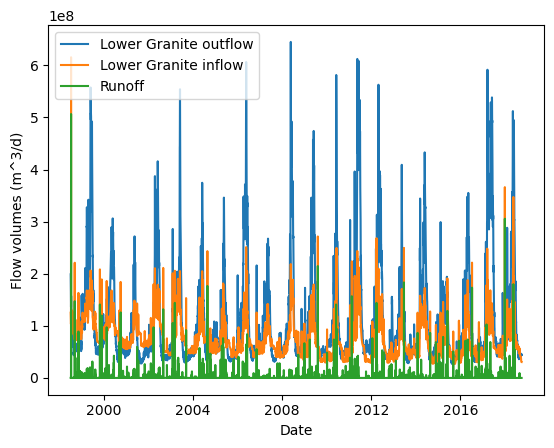

In [22]:
plt.plot(input_data['datetime'], input_data['Lower Granite outflow (cfs)']*86400*0.0283, label='Lower Granite outflow')
plt.plot(input_data['datetime'], input_data['Lower Granite inflow (m^3/d)'], label='Lower Granite inflow')
plt.plot(input_data['datetime'], runoff, label='Runoff')

plt.legend()
plt.xlabel('Date')
plt.ylabel('Flow volumes (m^3/d)')

506567445.106169


Text(0, 0.5, 'Flow volumes (m^3/d)')

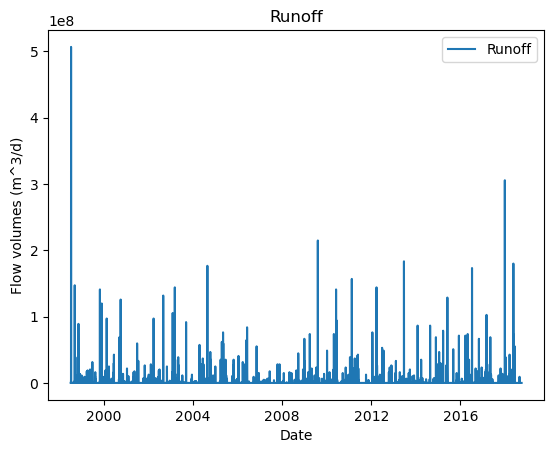

In [23]:
plt.plot(input_data['datetime'], runoff, label='Runoff')
print(max(runoff))
plt.legend()
plt.title('Runoff')
plt.xlabel('Date')
plt.ylabel('Flow volumes (m^3/d)')

Text(0, 0.5, 'Flow volumes (m^3/d)')

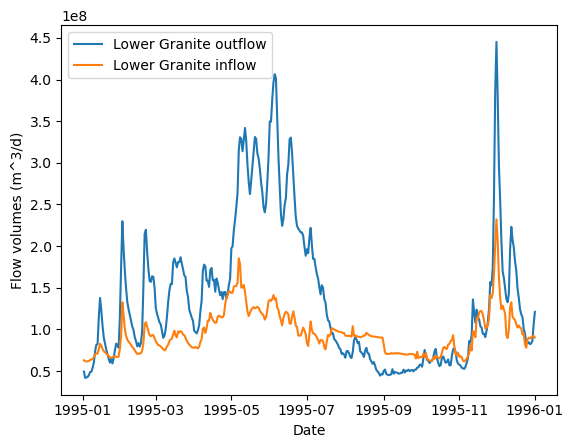

In [12]:
plt.plot(input_data['datetime'][:365], input_data['Lower Granite outflow (cfs)'][:365]*86400*0.0283, label='Lower Granite outflow')
plt.plot(input_data['datetime'][:365], input_data['Lower Granite inflow (m^3/d)'][:365], label='Lower Granite inflow')

plt.legend()
plt.xlabel('Date')
plt.ylabel('Flow volumes (m^3/d)')

Text(0, 0.5, 'Flow volumes (m^3/d)')

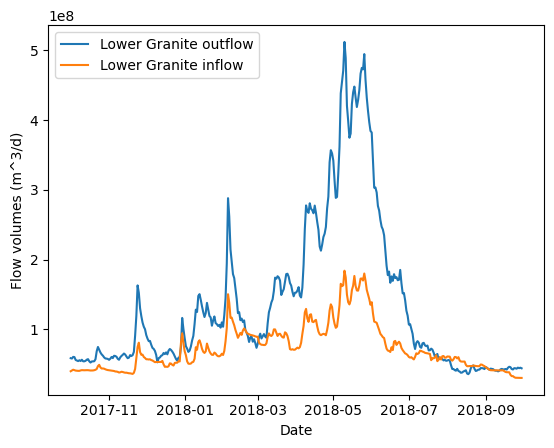

In [13]:
plt.plot(input_data['datetime'][-365:], input_data['Lower Granite outflow (cfs)'][-365:]*86400*0.0283, label='Lower Granite outflow')
plt.plot(input_data['datetime'][-365:], input_data['Lower Granite inflow (m^3/d)'][-365:], label='Lower Granite inflow')

plt.legend()
plt.xlabel('Date')
plt.ylabel('Flow volumes (m^3/d)')

Text(0, 0.5, 'Reservoir storage (m^3)')

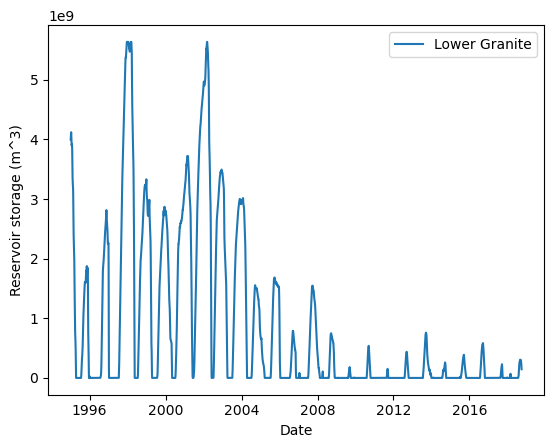

In [14]:
# sns.lineplot(x='datetime', y='Ice Harbor outflow (cfs)', data=input_data, label='Ice Harbor')
# sns.lineplot(x='datetime', y='Lower Monumental outflow (cfs)', data=input_data, label='Lower Monumental')
# sns.lineplot(x='datetime', y='Little Goose outflow (cfs)', data=input_data, label='Little Goose')
sns.lineplot(x='datetime', y='Lower granite storage (m^3)', data=input_data, label='Lower Granite')

#plt.yscale('log')
plt.xlabel('Date')
plt.ylabel('Reservoir storage (m^3)')

### Little Goose

In [15]:
input_data['Little Goose inflow (m^3/d)'] = little_goose.simulate_inflow(input_data['rainfall (in)'].values, input_data['Lower Granite outflow (cfs)'])
input_data['Little Goose storage (m^3)'] = little_goose.simulate_storage(5_000_000_000, 1, input_data['Little Goose inflow (m^3/d)'].values, input_data['Little Goose outflow (cfs)'].values*86400*0.0283)

display(input_data)

[0. 0. 0. ... 0. 0. 0.]


,datetime,Ice Harbor outflow (cfs),Lower Monumental outflow (cfs),Little Goose outflow (cfs),Lower Granite outflow (cfs),upstream flow (cfs),rainfall (in),Lower Granite inflow (m^3/d),Lower granite storage (m^3),Little Goose inflow (m^3/d),Little Goose storage (m^3)
1543,1995-01-02,21588,21840,20664,20171,25758.958333,0.00,6.298374e+07,4.000000e+09,49320515.52,5.000000e+09
1544,1995-01-03,18241,18326,17304,17089,25305.937500,0.00,6.187605e+07,4.020091e+09,41784655.68,4.999474e+09
1545,1995-01-04,18355,18226,17294,17289,25167.812500,0.00,6.153832e+07,4.039356e+09,42273679.68,4.999462e+09
1546,1995-01-05,18512,18348,17432,17595,25255.833333,0.00,6.175354e+07,4.058088e+09,43021886.40,4.999861e+09
1547,1995-01-06,18792,19001,18121,18514,25436.458333,0.01,6.219519e+07,4.075014e+09,45268951.68,5.000822e+09
...,...,...,...,...,...,...,...,...,...,...,...
10175,2018-09-26,17428,18068,17945,17918,12562.083333,0.00,3.071580e+07,2.022563e+08,43811660.16,5.134078e+09
10176,2018-09-27,17526,18607,18484,18519,12548.105263,0.00,3.068162e+07,1.876567e+08,45281177.28,5.134164e+09
10177,2018-09-28,17245,18291,18170,18192,12532.187500,0.00,3.064270e+07,1.738178e+08,44481623.04,5.134217e+09
10178,2018-09-29,17863,18637,18515,18493,12505.416667,0.00,3.057724e+07,1.591774e+08,45217604.16,5.134164e+09


Text(0, 0.5, 'Reservoir storage (m^3)')

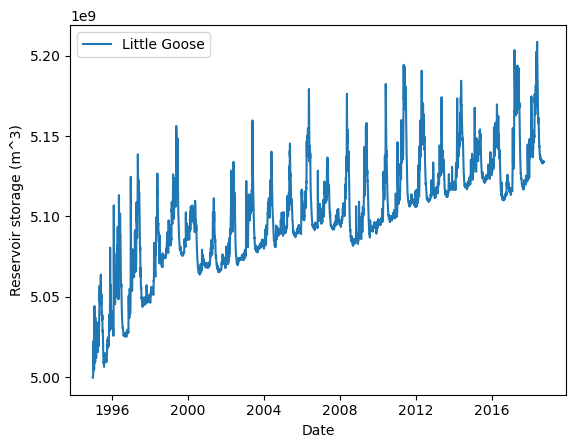

In [16]:
#sns.lineplot(x='datetime', y='Lower granite storage (m^3)', data=input_data, label='Lower Granite')
sns.lineplot(x='datetime', y='Little Goose storage (m^3)', data=input_data, label='Little Goose')

#plt.yscale('log')
plt.xlabel('Date')
plt.ylabel('Reservoir storage (m^3)')

### Lower Monumental

In [17]:
input_data['Lower Monumental inflow (m^3/d)'] = lower_monumental.simulate_inflow(input_data['rainfall (in)'].values, input_data['Little Goose outflow (cfs)'])
input_data['Lower Monumental storage (m^3)'] = lower_monumental.simulate_storage(5_000_000_000, 1, input_data['Lower Monumental inflow (m^3/d)'].values, input_data['Lower Monumental outflow (cfs)'].values*86400*0.0283)

display(input_data)

[0. 0. 0. ... 0. 0. 0.]


,datetime,Ice Harbor outflow (cfs),Lower Monumental outflow (cfs),Little Goose outflow (cfs),Lower Granite outflow (cfs),upstream flow (cfs),rainfall (in),Lower Granite inflow (m^3/d),Lower granite storage (m^3),Little Goose inflow (m^3/d),Little Goose storage (m^3),Lower Monumental inflow (m^3/d),Lower Monumental storage (m^3)
1543,1995-01-02,21588,21840,20664,20171,25758.958333,0.00,6.298374e+07,4.000000e+09,49320515.52,5.000000e+09,50525959.68,5.000000e+09
1544,1995-01-03,18241,18326,17304,17089,25305.937500,0.00,6.187605e+07,4.020091e+09,41784655.68,4.999474e+09,42310356.48,3.795103e+09
1545,1995-01-04,18355,18226,17294,17289,25167.812500,0.00,6.153832e+07,4.039356e+09,42273679.68,4.999462e+09,42285905.28,3.792824e+09
1546,1995-01-05,18512,18348,17432,17595,25255.833333,0.00,6.175354e+07,4.058088e+09,43021886.40,4.999861e+09,42623331.84,3.790584e+09
1547,1995-01-06,18792,19001,18121,18514,25436.458333,0.01,6.219519e+07,4.075014e+09,45268951.68,5.000822e+09,44308019.52,3.788432e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10175,2018-09-26,17428,18068,17945,17918,12562.083333,0.00,3.071580e+07,2.022563e+08,43811660.16,5.134078e+09,43877678.40,0.000000e+00
10176,2018-09-27,17526,18607,18484,18519,12548.105263,0.00,3.068162e+07,1.876567e+08,45281177.28,5.134164e+09,45195598.08,0.000000e+00
10177,2018-09-28,17245,18291,18170,18192,12532.187500,0.00,3.064270e+07,1.738178e+08,44481623.04,5.134217e+09,44427830.40,0.000000e+00
10178,2018-09-29,17863,18637,18515,18493,12505.416667,0.00,3.057724e+07,1.591774e+08,45217604.16,5.134164e+09,45271396.80,0.000000e+00


Text(0, 0.5, 'Reservoir storage (m^3)')

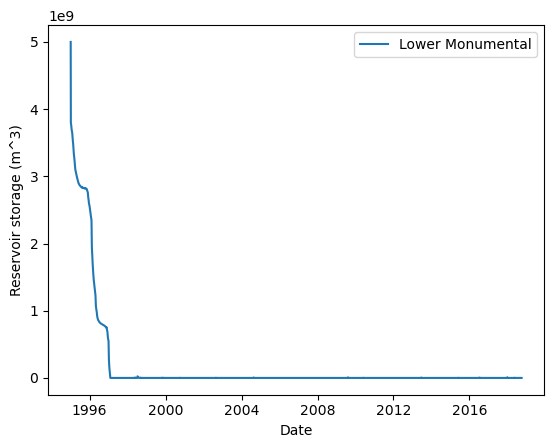

In [18]:
#sns.lineplot(x='datetime', y='Lower granite storage (m^3)', data=input_data, label='Lower Granite')
#sns.lineplot(x='datetime', y='Little Goose storage (m^3)', data=input_data, label='Little Goose')
sns.lineplot(x='datetime', y='Lower Monumental storage (m^3)', data=input_data, label='Lower Monumental')

#plt.yscale('log')
plt.xlabel('Date')
plt.ylabel('Reservoir storage (m^3)')

### Ice Harbor

In [19]:
input_data['Ice Harbor inflow (m^3/d)'] = ice_harbor.simulate_inflow(input_data['rainfall (in)'].values, input_data['Ice Harbor outflow (cfs)'])
input_data['Ice Harbor storage (m^3)'] = ice_harbor.simulate_storage(5_000_000_000, 1, input_data['Ice Harbor inflow (m^3/d)'].values, input_data['Ice Harbor outflow (cfs)'].values*86400*0.0283)

display(input_data)

[0. 0. 0. ... 0. 0. 0.]


,datetime,Ice Harbor outflow (cfs),Lower Monumental outflow (cfs),Little Goose outflow (cfs),Lower Granite outflow (cfs),upstream flow (cfs),rainfall (in),Lower Granite inflow (m^3/d),Lower granite storage (m^3),Little Goose inflow (m^3/d),Little Goose storage (m^3),Lower Monumental inflow (m^3/d),Lower Monumental storage (m^3),Ice Harbor inflow (m^3/d),Ice Harbor storage (m^3)
1543,1995-01-02,21588,21840,20664,20171,25758.958333,0.00,6.298374e+07,4.000000e+09,49320515.52,5.000000e+09,50525959.68,5.000000e+09,52785250.56,5.000000e+09
1544,1995-01-03,18241,18326,17304,17089,25305.937500,0.00,6.187605e+07,4.020091e+09,41784655.68,4.999474e+09,42310356.48,3.795103e+09,44601433.92,5.000000e+09
1545,1995-01-04,18355,18226,17294,17289,25167.812500,0.00,6.153832e+07,4.039356e+09,42273679.68,4.999462e+09,42285905.28,3.792824e+09,44880177.60,5.000000e+09
1546,1995-01-05,18512,18348,17432,17595,25255.833333,0.00,6.175354e+07,4.058088e+09,43021886.40,4.999861e+09,42623331.84,3.790584e+09,45264061.44,5.000000e+09
1547,1995-01-06,18792,19001,18121,18514,25436.458333,0.01,6.219519e+07,4.075014e+09,45268951.68,5.000822e+09,44308019.52,3.788432e+09,45948695.04,5.000000e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10175,2018-09-26,17428,18068,17945,17918,12562.083333,0.00,3.071580e+07,2.022563e+08,43811660.16,5.134078e+09,43877678.40,0.000000e+00,42613551.36,5.063606e+09
10176,2018-09-27,17526,18607,18484,18519,12548.105263,0.00,3.068162e+07,1.876567e+08,45281177.28,5.134164e+09,45195598.08,0.000000e+00,42853173.12,5.063606e+09
10177,2018-09-28,17245,18291,18170,18192,12532.187500,0.00,3.064270e+07,1.738178e+08,44481623.04,5.134217e+09,44427830.40,0.000000e+00,42166094.40,5.063606e+09
10178,2018-09-29,17863,18637,18515,18493,12505.416667,0.00,3.057724e+07,1.591774e+08,45217604.16,5.134164e+09,45271396.80,0.000000e+00,43677178.56,5.063606e+09


Text(0, 0.5, 'Reservoir storage (m^3)')

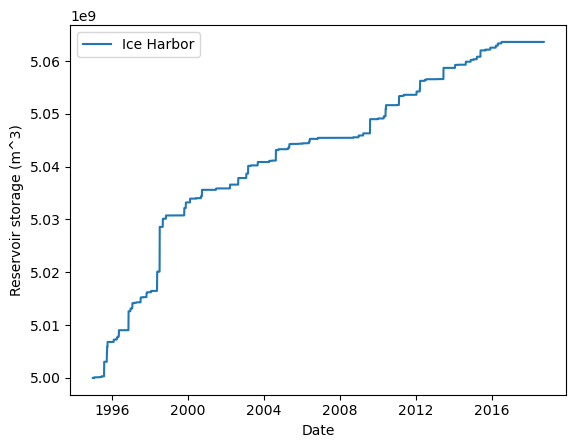

In [20]:
sns.lineplot(x='datetime', y='Ice Harbor storage (m^3)', data=input_data, label='Ice Harbor')

#plt.yscale('log')
plt.xlabel('Date')
plt.ylabel('Reservoir storage (m^3)')

### Visualize all reservoirs

Text(0, 0.5, 'Reservoir storage (m^3)')

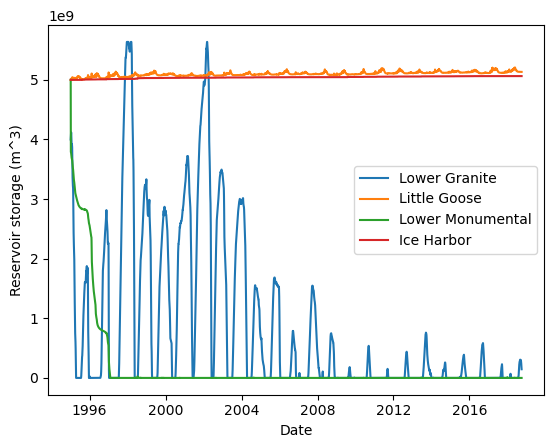

In [21]:
sns.lineplot(x='datetime', y='Lower granite storage (m^3)', data=input_data, label='Lower Granite')
sns.lineplot(x='datetime', y='Little Goose storage (m^3)', data=input_data, label='Little Goose')
sns.lineplot(x='datetime', y='Lower Monumental storage (m^3)', data=input_data, label='Lower Monumental')
sns.lineplot(x='datetime', y='Ice Harbor storage (m^3)', data=input_data, label='Ice Harbor')

plt.xlabel('Date')
plt.ylabel('Reservoir storage (m^3)')

## OLD: Simulate reservoirs

In [22]:
x = 0
res_info = pd.DataFrame({'Names':['Ice Harbor','Lower Monumental','Little Goose','Lower Granite'],
                         'Reservoir surface area (m^2)':[9200*4047,6590*4047,10025*4047,8900*4047],
                         'Number of turbines':[6,6,6,6],
                         'Generation capacity (kW)':[603000,810000,903000,810000],
                         'Average tailwater elevation (m)':[339,439,539,636],
                         'Maximum pooling elevation (m)':[446.0,548.3,646.5,746.5],
                         'Fish Passage Rate (%)':[.965,.965,.9775,x],
                         'Watershed Area (acres)':[103_352,95_277,83_074,111_602]
                         })
res_info['Generation capacity (kW)'] = pd.to_numeric(res_info['Generation capacity (kW)'])
display(res_info)

eta = 0.8 # efficiency of turbines, assumed value
rho = 998 # density of water, 1000 kg/m^3
g = 9.81 # gravitational acceleration, 9.81 m/s^2

# generate inflow from previous reservoir outflow/gage data, and added runoff data
# PLACEHOLDER
def simulate_inflow(data):
    return data*1.1

# simulate reservoir
def simulate_reservoir(df, initial_storage, keep, resID):
    # df is a dataframe containing reservoir data. Has columns 'inflow (cfs)'
    #       and 'outflow (cfs)'. Timestep is in days.
    # keep is a boolean. Keep = 0, remove = 1
    # resID is the string name of the reservoir
    # this function will directly modify a DataFrame!
    info = res_info[res_info['Names'] == resID].iloc[0]
    df['storage (cf)'] = 3000000
    max_storage = info['Maximum pooling elevation (m)']*info['Reservoir surface area (m^2)']
    df.loc[0,'storage (cf)'] = initial_storage
    if keep == 0:
        df['storage (cf)'] = df['storage (cf)'].cumsum() + (df['inflow (cfs)'] - df['outflow (cfs)'])*86400
        df['storage (m^3)'] = np.minimum(df['storage (cf)']/35.315,max_storage)
        df['elevation head (m)'] = df['storage (m^3)']/info['Reservoir surface area (m^2)']
        df['power produced (kWh)'] = np.minimum(eta*rho*g*df['elevation head (m)']*df['storage (cf)']*info['Number of turbines'], info['Generation capacity (kW)'])
    else:
        df['storage (cf)'] = 0
        df['elevation head (m)'] = 0
        df['power produced (kWh)'] = 0
        df['outflow (cfs)'] = df['inflow (cfs)']

    return None

# simulate the whole system
def simulate_system(df):
    # - df is dataframe with Ice Harbor, Lower Monumental, Little Goose, and Lower Granite
    return None

,Names,Reservoir surface area (m^2),Number of turbines,Generation capacity (kW),Average tailwater elevation (m),Maximum pooling elevation (m),Fish Passage Rate (%),Watershed Area (acres)
0,Ice Harbor,37232400,6,603000,339,446.0,0.9650,103352
1,Lower Monumental,26669730,6,810000,439,548.3,0.9650,95277
2,Little Goose,40571175,6,903000,539,646.5,0.9775,83074
3,Lower Granite,36018300,6,810000,636,746.5,0.0000,111602


In [23]:
# simulate Lower Granite reservoir
lower_granite = pd.DataFrame(outflow_data['Lower Granite outflow (cfs)'])
lower_granite['inflow (cfs)'] = input_data['upstream flow (cfs)']
lower_granite.rename(columns={'Lower Granite outflow (cfs)':'outflow (cfs)'}, inplace=True)
display(lower_granite)
simulate_reservoir(lower_granite,100000,0,'Lower Granite')
display(lower_granite)

,outflow (cfs),inflow (cfs)
0,56639,NaN
1,49861,NaN
2,46219,NaN
3,45121,NaN
4,41992,NaN
...,...,...
32959,17918,NaN
32960,18519,NaN
32961,18192,NaN
32962,18493,NaN


,outflow (cfs),inflow (cfs),storage (cf),storage (m^3),elevation head (m),power produced (kWh)
0,56639,NaN,NaN,NaN,NaN,NaN
1,49861,NaN,NaN,NaN,NaN,NaN
2,46219,NaN,NaN,NaN,NaN,NaN
3,45121,NaN,NaN,NaN,NaN,NaN
4,41992,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
32959,17918,NaN,NaN,NaN,NaN,NaN
32960,18519,NaN,NaN,NaN,NaN,NaN
32961,18192,NaN,NaN,NaN,NaN,NaN
32962,18493,NaN,NaN,NaN,NaN,NaN
